# [프로젝트4] RNN 기반 모델(LSTM)로 이상치 탐지하기

## 프로젝트 목표
---

LSTM 모델을 사용하여 MME 장비의 이상치 탐지

## 프로젝트 목차
---
<div class="toc"><ul class="toc-item"><li><span><a href="#프로젝트-목표" data-toc-modified-id="프로젝트-목표-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>프로젝트 목표</a></span></li><li><span><a href="#프로젝트-목차" data-toc-modified-id="프로젝트-목차-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>프로젝트 목차</a></span></li><li><span><a href="#데이터-읽기" data-toc-modified-id="데이터-읽기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>데이터 읽기</a></span><ul class="toc-item"><li><span><a href="#라이브러리-설치" data-toc-modified-id="라이브러리-설치-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>라이브러리 설치</a></span></li><li><span><a href="#라이브러리-불러오기" data-toc-modified-id="라이브러리-불러오기-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>라이브러리 불러오기</a></span></li><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>데이터 불러오기</a></span></li></ul></li><li><span><a href="#데이터-준비하기" data-toc-modified-id="데이터-준비하기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>데이터 준비하기</a></span><ul class="toc-item"><li><span><a href="#Train,-Test-데이터-선택" data-toc-modified-id="Train,-Test-데이터-선택-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Train, Test 데이터 선택</a></span></li><li><span><a href="#데이터-정규화" data-toc-modified-id="데이터-정규화-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>데이터 정규화</a></span></li></ul></li><li><span><a href="#Multivariate-LSTM-Forecast-Model" data-toc-modified-id="Multivariate-LSTM-Forecast-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Multivariate LSTM Forecast Model</a></span><ul class="toc-item"><li><span><a href="#[TODO]-TIME-STEP-설정-후-데이터-변경" data-toc-modified-id="[TODO]-TIME-STEP-설정-후-데이터-변경-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>[TODO] TIME STEP 설정 후 데이터 변경</a></span></li><li><span><a href="#신경망-생성" data-toc-modified-id="신경망-생성-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>신경망 생성</a></span></li><li><span><a href="#LSTM-모델-학습" data-toc-modified-id="LSTM-모델-학습-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>LSTM 모델 학습</a></span></li><li><span><a href="#모델-학습-결과-확인-및-시각화" data-toc-modified-id="모델-학습-결과-확인-및-시각화-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>모델 학습 결과 확인 및 시각화</a></span></li><li><span><a href="#이상치-확인하기" data-toc-modified-id="이상치-확인하기-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>이상치 확인하기</a></span></li></ul></li></ul></div>


## 데이터 읽기

---

### 라이브러리 불러오기
---

본 프로젝트에 필요한 라이브러리를 불러옵니다.

In [1]:
import copy
import IPython
import warnings
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# *- torch -* 
import torch
import torch.nn as nn
from torch.utils.data import ( Dataset, DataLoader, random_split) 


%matplotlib inline
warnings.filterwarnings(action='ignore') # warning ignore 
pd.options.display.max_rows = 80
pd.options.display.max_columns = 80
sns.set_style("whitegrid")

SEED = 2022
np.random.seed(SEED)
torch.manual_seed(SEED)

### 데이터 불러오기
---

프로젝트 1에서 전처리가 끝난 데이터(`MME_data.p`) 를 불러옵니다. 또한 기기별로 이상치 탐지를 하기 위하여 기기 정보를 devices로 저장해 놓도록 합니다. 

In [2]:
# load 
with open('./MME_data.p', 'rb') as fp:
    total_df = pickle.load(fp)

In [3]:
# 데이터를 쉽게 불러오기 위하여 기기를 정의
devices = [
    "MME017",
    "MME018",
    "MME071",
    "MME072",
    "MME073",
    "MME074",
    "MME091",
    "MME092",
    "MME093",
]

In [4]:
feature_dict = {
    "comb_atch_att_45005": "국내가입자 attach 시도호",
    "comb_atch_att_etc": "인바운드로머 attach 시도호",
    "ue_dtch_att": "가입자에 의한 detach 시도호",
    "net_dtch_att": "장비에 의한 detach 시도호",
    "srmo_att": "데이터 발신 시도",
    "srmt_att": "데이터 착신 시도",
    "comb_tau_att": "위치 등록 시도",
    "prd_tau_att": "주기적 위치등록 시도",
    "pag_data_att": "데이터 페이징 시도",
    "pag_hdv_att": "hdvoice 페이징 시도",
    "pag_sms_att": "sms 페이징 시도",
    "pag_video_att": "영상통화 페이징 시도",
    "ddn_att": "downlink data noti. 시도",
    "comb_atch_succ_rate_45005": "국내가입자 attach 성공율",
    "comb_atch_succ_rate_etc": "인바운드로머 attach 성공율",
    "ue_dtch_succ_rate": "가입자에 의한 detach 성공율",
    "net_dtch_succ_rate": "장비에 의한 detach 성공율",
    "srmo_succ_rate": "데이터 발신 성공율",
    "srmt_succ_rate": "데이터 착신 성공율",
    "comb_tau_succ_rate": "위치 등록 성공율",
    "prd_tau_succ_rate": "주기적 위치등록 성공율",
    "pag_data_succ_rate": "데이터 페이징 성공율",
    "pag_hdv_succ_rate": "hdvoice 페이징 성공율",
    "pag_sms_succ_rate": "sms 페이징 성공율",
    "pag_video_succ_rate": "영상통화 페이징 성공율",
    "ddn_succ_rate": "downlink data noti. 성공율",
}
att_features = list(feature_dict.keys())[:13]
rate_features = list(feature_dict.keys())[13:]


## 데이터 준비하기
---

### Train, Test 데이터 선택

LSTM 모델을 학습하기 위한 훈련 데이터와 테스트 데이터를 설정합니다.

한 기기에서 변수 몇가지를 골라서 앞 시간대는 훈련 데이터로, 뒷 시간대는 테스트 데이터로 설정합니다.

사용할 변수는 아래와 같습니다.
- `comb_atch_att_45005`
- `comb_atch_att_etc`
- `comb_atch_succ_rate_45005`

In [5]:
# 첫 번째 기기를 선택 합니다. 
devide_df = total_df[devices[0]]

# 훈련 데이터를 70%, 테스트 데이터를 30%로 분리합니다.
train_size = int(len(devide_df) * 0.7)

train_df = devide_df.iloc[:train_size, :]
test_df = devide_df.iloc[train_size:, :]

In [6]:
######################################
# 변수 3개 선택하기
######################################
selected_variable = [
    "comb_atch_att_45005",
    "comb_atch_att_etc",
    "comb_atch_succ_rate_45005",
]

-----------TRAIN-------------------
Train data shape:  (116, 3)


variable,comb_atch_att_45005,comb_atch_att_etc,comb_atch_succ_rate_45005
ds,,,
2022-03-07 09:00:00,24075.0,26716.0,79.26
2022-03-07 10:00:00,22481.0,26302.0,76.78
2022-03-07 11:00:00,22482.0,25515.0,75.42
2022-03-07 12:00:00,21658.0,25714.0,74.93
2022-03-07 13:00:00,22828.0,24949.0,76.48


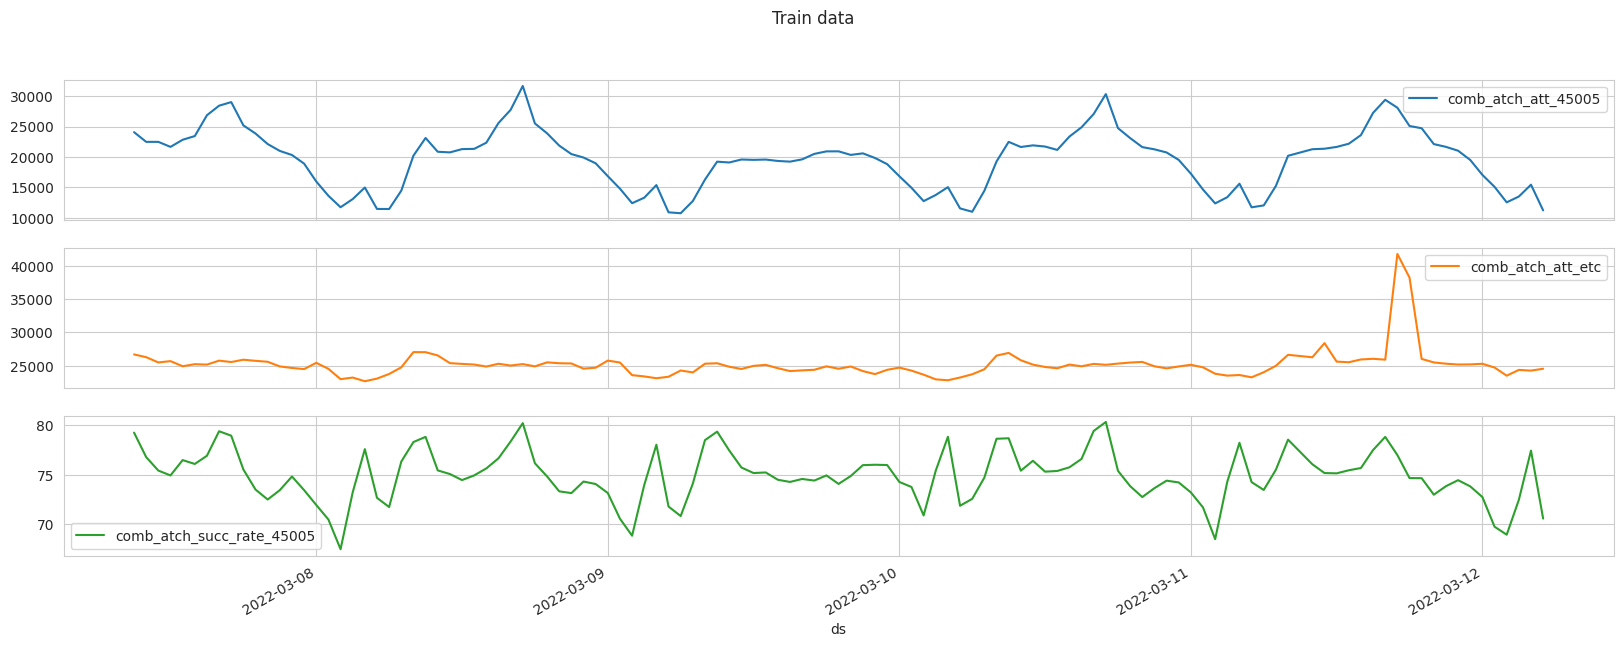

-----------TEST-------------------
Test data shape:  (51, 3)


variable,comb_atch_att_45005,comb_atch_att_etc,comb_atch_succ_rate_45005
ds,,,
2022-03-12 06:00:00,11094.0,25303.0,69.42
2022-03-12 07:00:00,12752.0,25838.0,72.27
2022-03-12 08:00:00,16085.0,27234.0,76.43
2022-03-12 09:00:00,20014.0,26454.0,78.81
2022-03-12 10:00:00,20767.0,25884.0,76.71


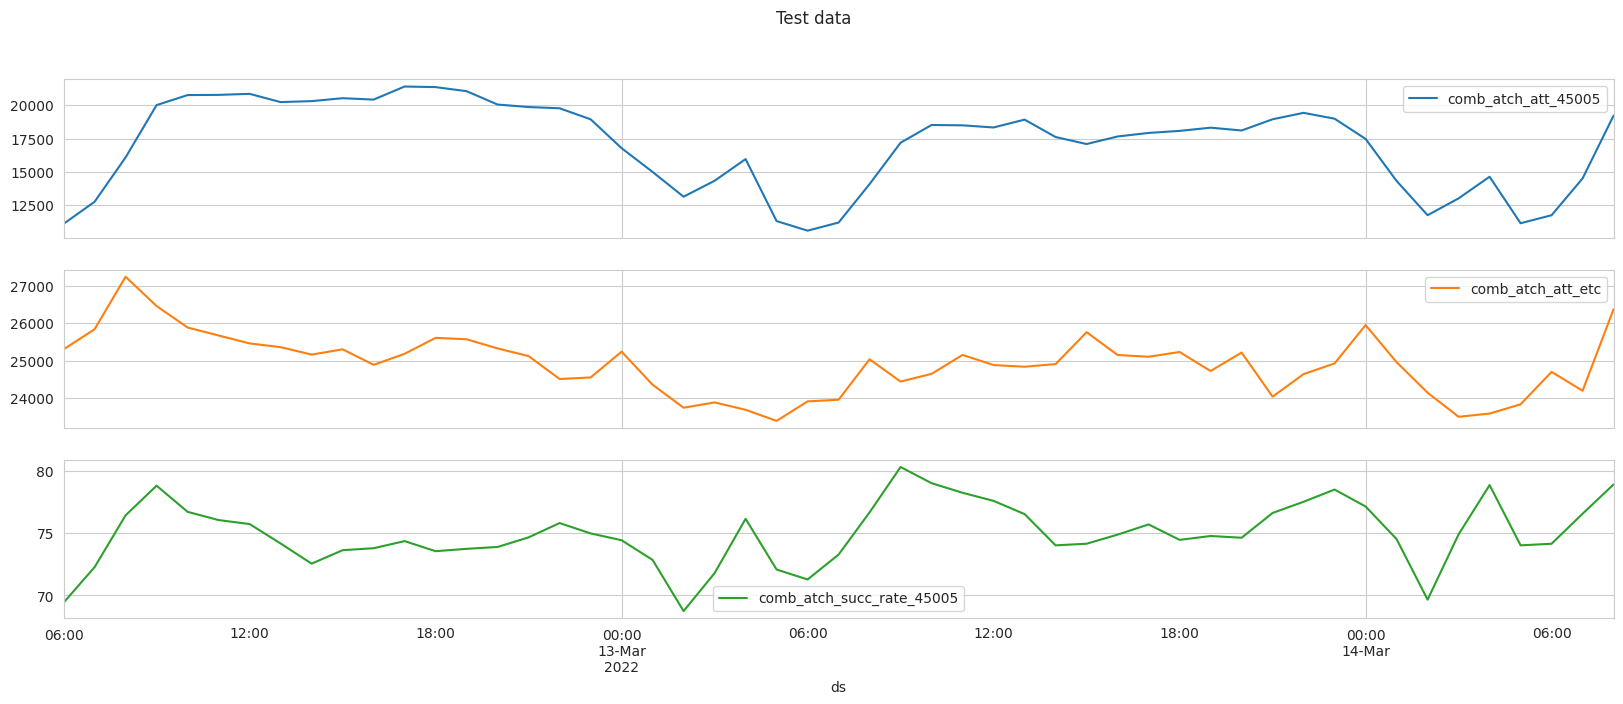

In [7]:
# 선택된 데이터 확인하기
print("-----------TRAIN-------------------")
train_df = train_df[selected_variable]
print("Train data shape: ", train_df.shape)
display(train_df.head())
train_df.plot(subplots=True, figsize=(20, 7), title="Train data")
plt.show()


print("-----------TEST-------------------")
test_df = test_df[selected_variable][: len(train_df)]
print("Test data shape: ", test_df.shape)
display(test_df.head())
test_df.plot(subplots=True, figsize=(20, 7), title="Test data")
plt.show()


### 데이터 정규화

신경망 모델을 훈련시키기 위해서는 정규화가 필수입니다. 이에 표준정규화를 각각 해주도록 합니다.

In [8]:
# standard scaling 
scaler = StandardScaler()
scaler = scaler.fit(train_df[selected_variable])

train_df[selected_variable] = scaler.transform(train_df[selected_variable])
test_df[selected_variable] = scaler.transform(test_df[selected_variable])

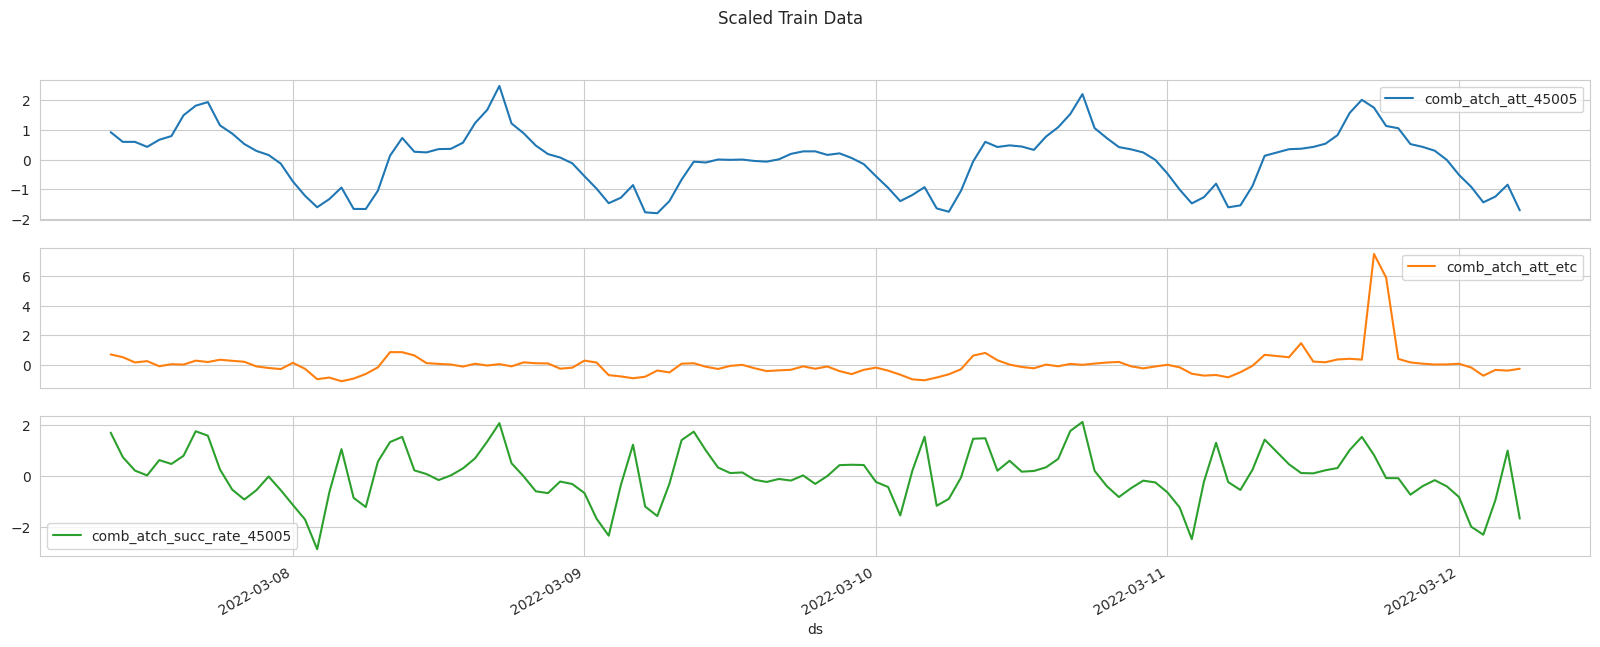

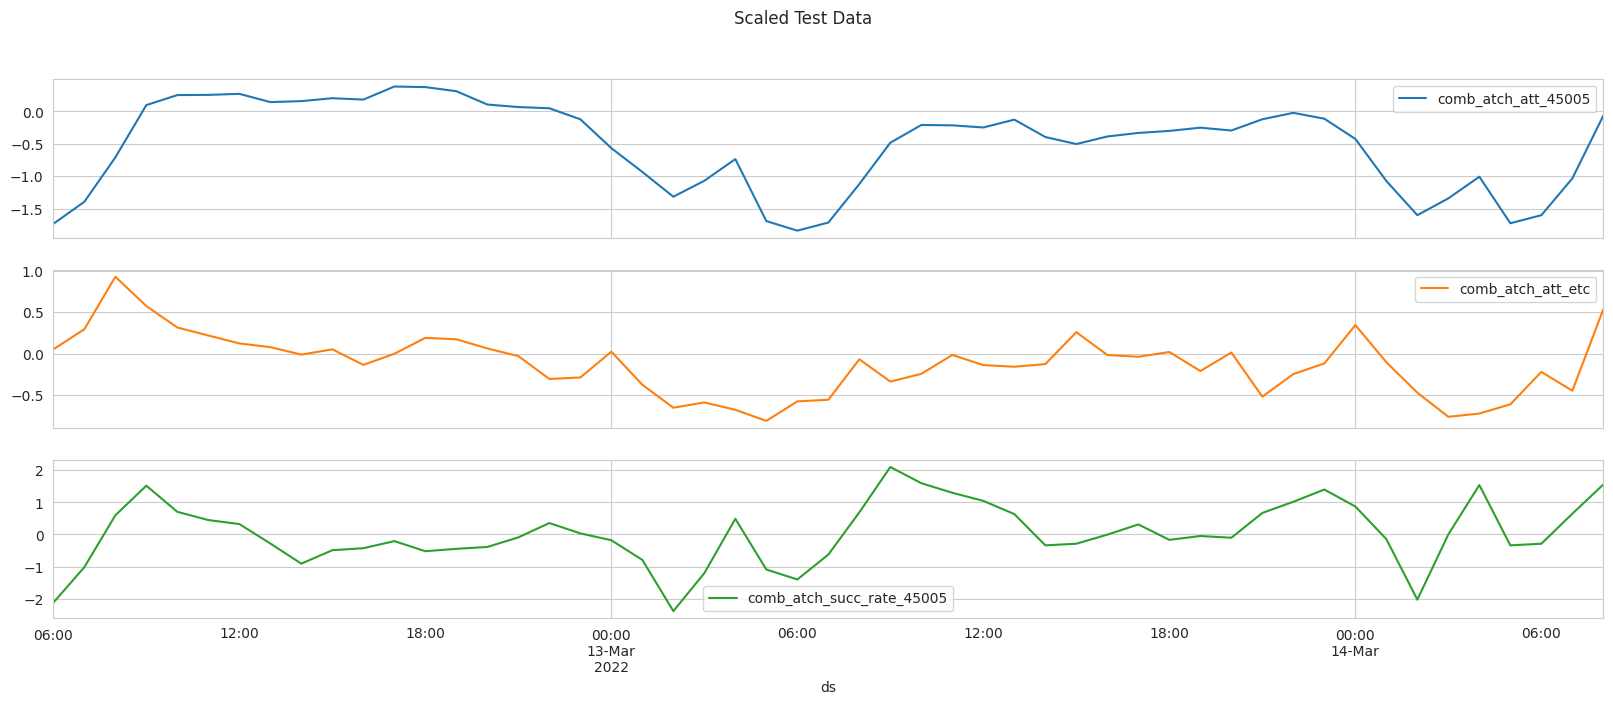

In [9]:
# 정규화 확인
train_df[selected_variable].plot(
    subplots=True, figsize=(20, 7), title="Scaled Train Data"
)
test_df[selected_variable].plot(
    subplots=True, figsize=(20, 7), title="Scaled Test Data"
)
plt.show()


##  Multivariate LSTM Forecast Model

### [TODO] TIME STEP 설정 후 데이터 변경

- 앞서 배운 것을 참조하여 주어진 데이터의 입력 너비를 조절해 봅니다. 
- 이때, Time step은 3으로 주도록 합니다. 


In [10]:
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i : (i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
        
    return np.array(Xs), np.array(ys)


In [11]:
# TIME_STEP 설정
TIME_STEP = 3

# TIME STEP 만큼 데이터 증가시키기
X_train, y_train = create_sequences(train_df, train_df, time_steps=TIME_STEP)
X_test, y_test = create_sequences(test_df, test_df, time_steps=TIME_STEP)

# 데이터 형태 확인
print("[INFO] Reshape input into [samples, timesteps, features]")
print(f"[INFO] Training shape: {X_train.shape}")
print(f"[INFO] Testing shape: {X_test.shape}")

[INFO] Reshape input into [samples, timesteps, features]
[INFO] Training shape: (113, 3, 3)
[INFO] Testing shape: (48, 3, 3)


### 신경망 생성

In [12]:
class Encoder(nn.Module):
    '''*- 인코더 -*'''
    def __init__(self, n_features, embedding_dim=32):
        super(Encoder, self).__init__()
        self.n_features =  n_features
        self.embedding_dim, self.hidden_dim = (
            embedding_dim, 2 * embedding_dim
        )
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        return  x[:,-1,:]

    
class Decoder(nn.Module):
    '''*- 디코더 -*'''
    def __init__(self, seq_len, input_dim=32, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=n_features,
            batch_first=True
        )
        
    def forward(self, x):
        x = x.reshape(-1,1,self.input_dim).repeat(1,self.seq_len,1)       
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.output_layer(x)
        return x


class RecurrentAutoencoder(nn.Module):
    '''*- 전체 모델 -*'''
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(n_features, embedding_dim)#.to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)#.to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RecurrentAutoencoder(seq_len=X_train.shape[1], n_features=X_train.shape[2], embedding_dim=16)
model = model.to(device)

print('--- 사용 할 RNN 기반 AutoEncoder 구조 ----\n')
print(model)

--- 사용 할 RNN 기반 AutoEncoder 구조 ----

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(3, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): LSTM(32, 3, batch_first=True)
  )
)


### LSTM 모델 학습

In [15]:
class ConfigDict(dict):
    def __init__(self):
        self.__dict__ = self


class AutoencoderDataset(Dataset):
    '''Array --> Torch Dataset'''
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx, :, :])
        return x
     

class Trainer:
    def __init__(self, model, cfg, device, train_dataset):
        self.cfg = cfg
        self.device = device
        self.train_dataset = train_dataset

        self.model, self.criterion, self.optimizer = self.compile_(model)
        self.train_dataloader, self.va_dataloader = self.create_trainloader(train_dataset)

        print('-'*86)
        print("\n".join(f"Argument: {k:<12s} ={v:>10}" for k, v in vars(self.cfg).items()))
        print("Argument: {:<12s} ={:>10}".format("DEVICE", device.__str__()))
        print('-'*86)
        print("\nOur Model:\t")
        print(self.model)
        print('-'*86)

    def create_trainloader(self, train_dataset):
        """make dataset and dataloader"""

        X_train_dataset = train_dataset

        total_len = len(X_train_dataset)
        valid_len = int(total_len* self.cfg.VALID_RATIO)

        train_dataset, valid_dataset = random_split(
            X_train_dataset, [total_len-valid_len, valid_len])
        train_dataloader = DataLoader(train_dataset,
                                        batch_size=self.cfg.BATCH_SIZE)
        va_dataloader = DataLoader(valid_dataset,
                                    batch_size=valid_len)

        return train_dataloader, va_dataloader


    def compile_(self, model):
        model = model.to(self.device)
        criterion = nn.__dict__[self.cfg.LOSS]().to(self.device)
        optimizer = torch.optim.__dict__[self.cfg.OPTIMIZER](model.parameters(), lr=1e-3)

        return model, criterion, optimizer

    def fit_(self):
        """train & valid """
        print('TRAINNIG START ...\n')
        history = dict(train=[], val=[])
        # best_model_wts = None
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = 10000.0

        for epoch in range(self.cfg.EPOCH):
            # training 
            self.model.train()
            train_losses = []
            for batch_idx, batch_x in enumerate(self.train_dataloader):
                self.optimizer.zero_grad()
                batch_x_tensor = batch_x.to(self.device)
                seq_pred = self.model(batch_x_tensor)
                loss = self.criterion(seq_pred, batch_x_tensor)
                loss.backward()
                self.optimizer.step()
                train_losses.append(loss.item())
            # validating 
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for batch_idx, va_x in enumerate(self.va_dataloader):
                    va_x_tensor = va_x.to(device)
                    seq_pred = self.model(va_x_tensor)
                    loss = self.criterion(seq_pred, va_x_tensor)
                    val_losses.append(loss.item())
            
            # stacking
            train_loss = np.mean(train_losses)
            val_loss = np.mean(val_losses)
            history['train'].append(train_loss)
            history['val'].append(val_loss)
        
            # save the best model 
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # print 
            if epoch % self.cfg.PRINT_FREQ ==0: 
                print(f'| Epoch {epoch:03d} | Train loss :{train_loss:.4f} | Val loss {val_loss:.4f} |')

        # Recover the best model
        model.load_state_dict(best_model_wts)
        return model, history

def plot_results(history, cfg):
    """summary for plot_results

    Args:
        history ([type]): [description]
        cfg ([type]): [description]
    """
    plt.title(f'Training&Validationg {cfg.LOSS}', fontsize=17)
    plt.plot(history["train"], label="Training Loss")
    plt.plot(history["val"], label="Validation Loss")
    plt.legend()
    plt.show()

In [16]:
#---------------------------
# ConfigDict
#---------------------------
# DON'T CHANGE THIS
config = ConfigDict()
config.EPOCH = 100 # TOTAL EPOCH 
config.LR = 1e-3 # Learning rate
config.BATCH_SIZE = 12 # bach size of dataset
config.VALID_RATIO = 0.2

# Changable variables 
config.OPTIMIZER = 'Adam' # or 'SGD'
config.LOSS = 'MSELoss' # or 'L1LOSS'
config.PRINT_FREQ = 5 # print period of log

In [17]:
# ------------------------
# Train the model
# ------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset = AutoencoderDataset(X_train)

trainer = Trainer(model, config, device, train_dataset)

--------------------------------------------------------------------------------------
Argument: EPOCH        =       100
Argument: LR           =     0.001
Argument: BATCH_SIZE   =        12
Argument: VALID_RATIO  =       0.2
Argument: OPTIMIZER    =      Adam
Argument: LOSS         =   MSELoss
Argument: PRINT_FREQ   =         5
Argument: DEVICE       =       cpu
--------------------------------------------------------------------------------------

Our Model:	
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(3, 32, batch_first=True)
    (rnn2): LSTM(32, 16, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(16, 16, batch_first=True)
    (rnn2): LSTM(16, 32, batch_first=True)
    (output_layer): LSTM(32, 3, batch_first=True)
  )
)
--------------------------------------------------------------------------------------


In [18]:
model, history = trainer.fit_()

TRAINNIG START ...

| Epoch 000 | Train loss :1.0208 | Val loss 1.1040 |
| Epoch 005 | Train loss :0.9736 | Val loss 1.0613 |
| Epoch 010 | Train loss :0.7640 | Val loss 0.8610 |
| Epoch 015 | Train loss :0.6870 | Val loss 0.8007 |
| Epoch 020 | Train loss :0.6487 | Val loss 0.7688 |
| Epoch 025 | Train loss :0.6164 | Val loss 0.7401 |
| Epoch 030 | Train loss :0.5894 | Val loss 0.7135 |
| Epoch 035 | Train loss :0.5731 | Val loss 0.6968 |
| Epoch 040 | Train loss :0.5597 | Val loss 0.6863 |
| Epoch 045 | Train loss :0.5350 | Val loss 0.6762 |
| Epoch 050 | Train loss :0.4970 | Val loss 0.6632 |
| Epoch 055 | Train loss :0.4832 | Val loss 0.6553 |
| Epoch 060 | Train loss :0.4739 | Val loss 0.6482 |
| Epoch 065 | Train loss :0.4644 | Val loss 0.6394 |
| Epoch 070 | Train loss :0.4482 | Val loss 0.6310 |
| Epoch 075 | Train loss :0.4383 | Val loss 0.6282 |
| Epoch 080 | Train loss :0.4332 | Val loss 0.6266 |
| Epoch 085 | Train loss :0.4296 | Val loss 0.6249 |
| Epoch 090 | Train loss :

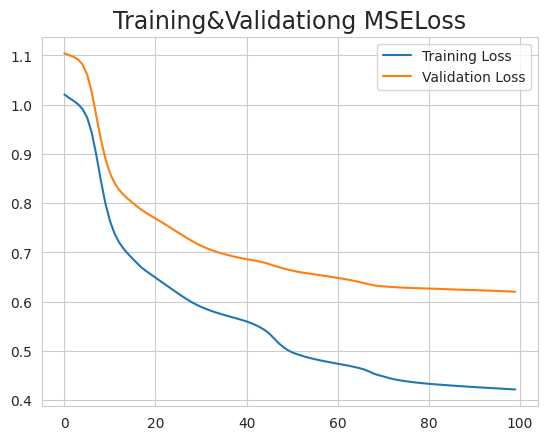

In [19]:
plot_results(history, config)

### 모델 학습 결과 확인 및 시각화 

In [20]:
class Tester:
    def __init__(self, model, cfg, device, test_dataset):
        self.cfg = cfg
        self.device = device
        # self.dataset = dataset
        self.model, self.criterion, self.optimizer = self.compile_(model)
        self.test_dataloader = self.create_test_dataloader(test_dataset)

    def create_test_dataloader(self, test_dataset):
        return  DataLoader(test_dataset, batch_size=1)


    def compile_(self, model):
        model = model.to(self.device)
        criterion = nn.__dict__[self.cfg.LOSS](reduction='sum').to(self.device)
        optimizer = torch.optim.__dict__[self.cfg.OPTIMIZER](model.parameters(), lr=1e-3)

        return model, criterion, optimizer

    def predict(self):
        predictions, losses = [], []
        with torch.no_grad():
            self.model.eval()
            for idx , seq_true in enumerate(self.test_dataloader):
                seq_true = seq_true.to(self.device)
                seq_pred = self.model(seq_true)
                loss = self.criterion(seq_pred, seq_true)
                predictions.append(seq_pred.cpu().numpy().flatten())
                losses.append(loss.item())

        return predictions, losses

In [21]:
# 모델 사용하여 예측
test_dataset = AutoencoderDataset(X_test)
predictions, pred_losses = Tester(model, config,device, test_dataset).predict()

# 3개 feature의 예측갑소가 mae 로스 구하기 
test_prediction = np.array(predictions).reshape(len(predictions),
                                                 X_test.shape[1],
                                                 X_test.shape[2]
                                                )
test_mae_loss = np.mean(np.abs(test_prediction-X_test), axis=1)



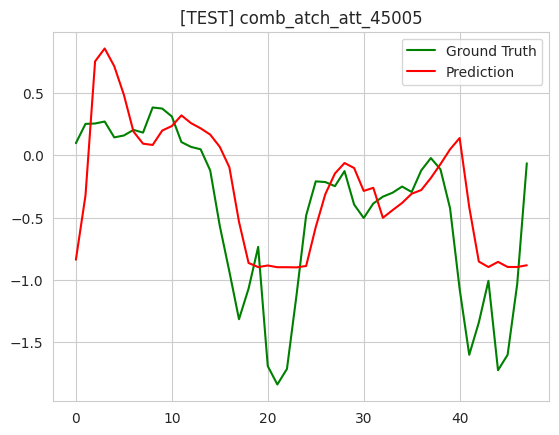

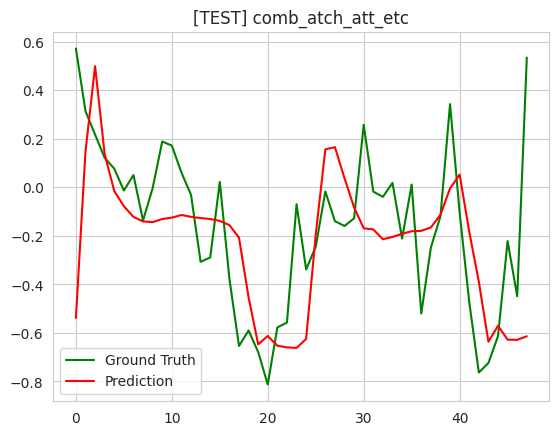

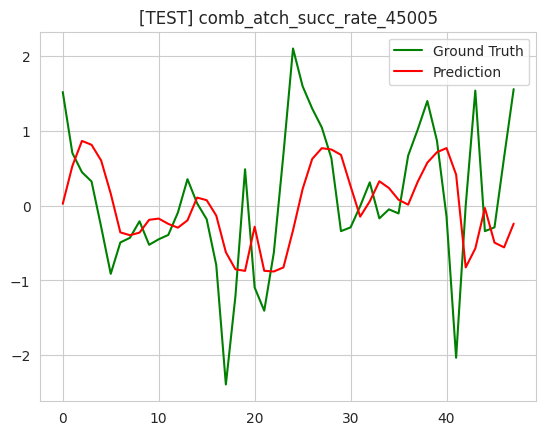

In [22]:
# 예측값 그래프 그리기 
prediction_ = np.mean(test_prediction, axis=1)
total_indices = list(range(len(prediction_)))

for idx, column_name in enumerate(selected_variable):
    plt.title(f"[TEST] {column_name}")
    plt.plot(total_indices, y_test[:, idx], color="green", label="Ground Truth")
    plt.plot(total_indices, prediction_[:, idx], color="r", label="Prediction")
    plt.legend()
    plt.show()

### 이상치 확인하기

In [23]:
def detect_anomalies(testing, train_mae_loss, test_mae_loss, threshold_value):
    ##################################
    # 1. 임계치 넘는 이상치 탐지 
    ##################################
    anomalies = test_mae_loss > threshold_value
    print("[INFO] 임계치(threshold): {:.4f}".format(threshold_value))
    print("[INFO] 임계치 넘는 이상치 개수: {}/{}".format(np.sum(anomalies), len(test_mae_loss)))
    
    ##################################
    # 2. DataFrame 만들기
    #################################
    df = pd.DataFrame()
    df['ds'] = list(range(len(testing)))
    df['y'] = testing
    df['anomaly'] = anomalies
    df['anomaly'] = df['anomaly'].map({True:1,False:0})

    return df 

def plot_anomalies(pred):
    ''' plotting function'''
    total_indices = list(range(len(pred)))
    total_values = pred["y"].values
    abnormal_indices = pred[pred["anomaly"] != 0].index.values
    abnormal_values = pred[pred["anomaly"] != 0]["y"].values

   
    plt.plot(total_indices, total_values, color="green")
    plt.scatter(abnormal_indices, abnormal_values, color="r")
    plt.show()

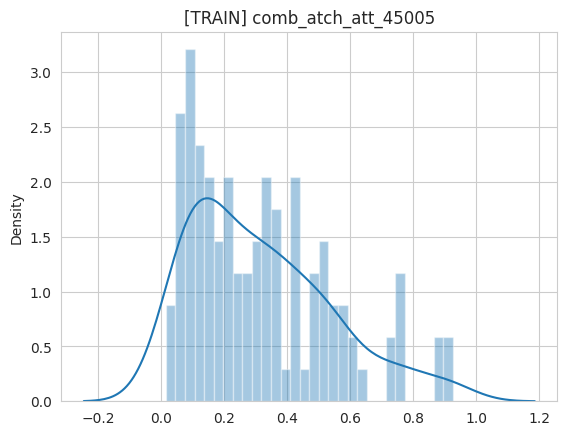

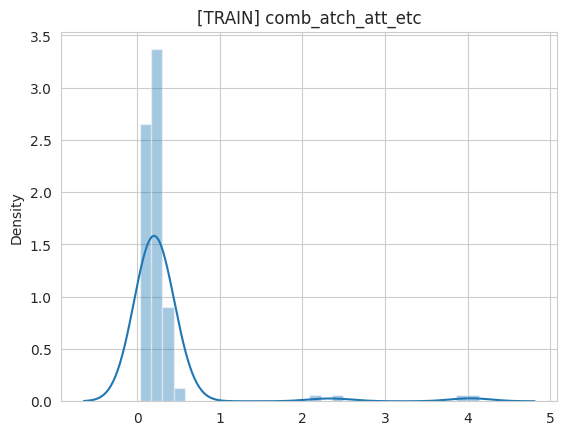

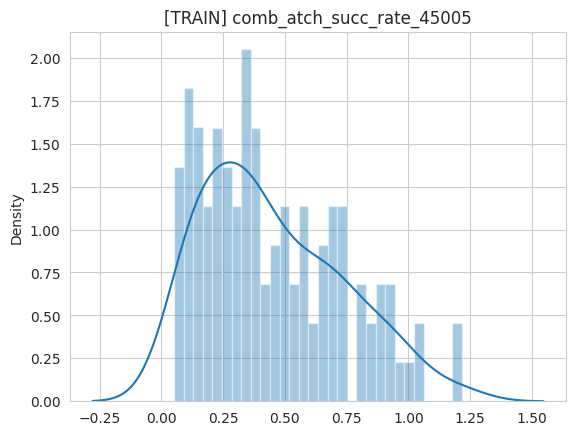

In [26]:
# train MAE 얻기 
X_train_pred, _ = Tester(model, config,device, train_dataset).predict()
# predict(model, X_train)
predictions = np.array(X_train_pred).reshape(len(X_train_pred),
                                                 X_train.shape[1],
                                                 X_train.shape[2]
                                                )
train_mae_loss = np.mean(np.abs(predictions - X_train), axis=1)

# train MAE 분포 그리기 
total_indices = len(train_mae_loss)
for idx, column_name in enumerate(selected_variable):
    plt.title(f"[TRAIN] {column_name}")
    sns.distplot(train_mae_loss[:, idx], bins=30, kde=True)
    plt.show()

### [TODO] 임계값 설정하기 

위에 MAE 분포를 확인하고 그에 맞는 임계값을 각 각 설정합니다. 

In [27]:
# 임계값 설정 하기 
THRESHOLD_1 = 0.3
THRESHOLD_2 = 0.4
THRESHOLD_3 = 0.5

[INFO] 임계치(threshold): 0.3000
[INFO] 임계치 넘는 이상치 개수: 19/48


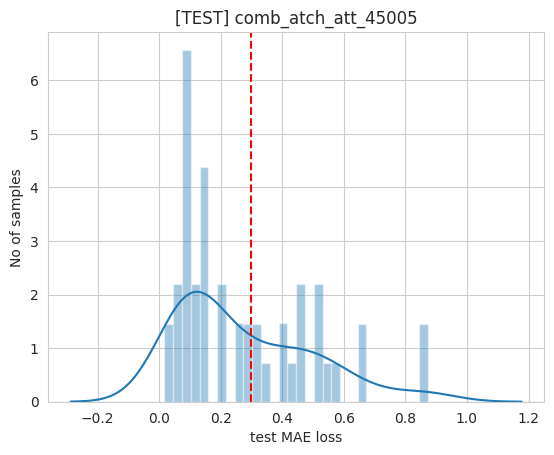

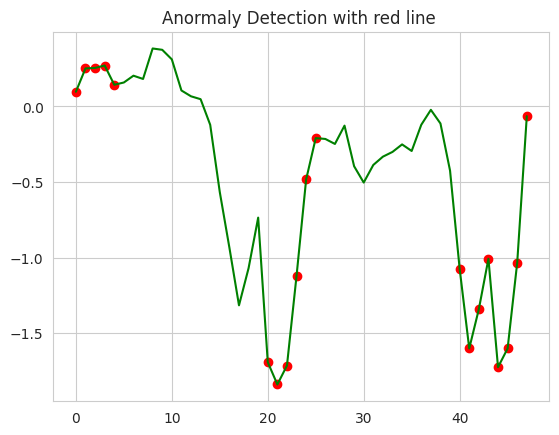

--------------------------------------------------------------------------------
[INFO] 임계치(threshold): 0.4000
[INFO] 임계치 넘는 이상치 개수: 4/48


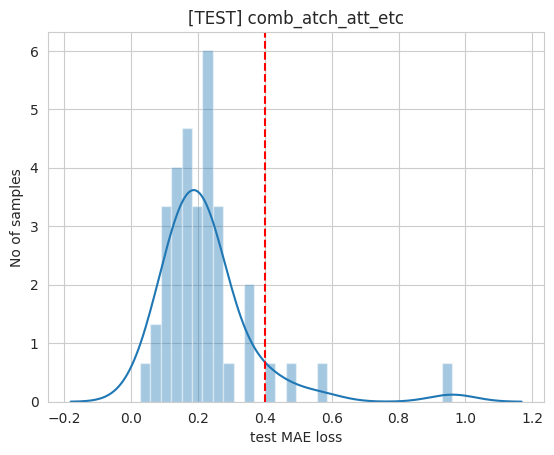

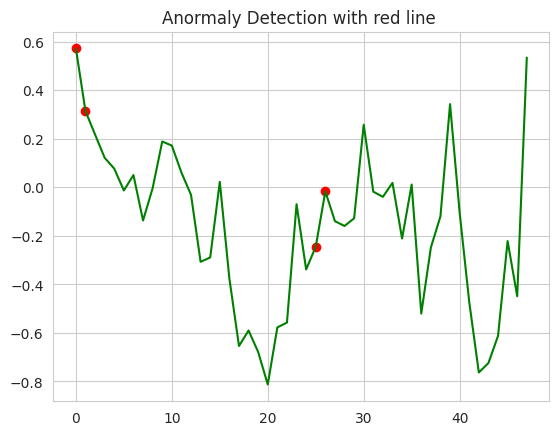

--------------------------------------------------------------------------------
[INFO] 임계치(threshold): 0.5000
[INFO] 임계치 넘는 이상치 개수: 17/48


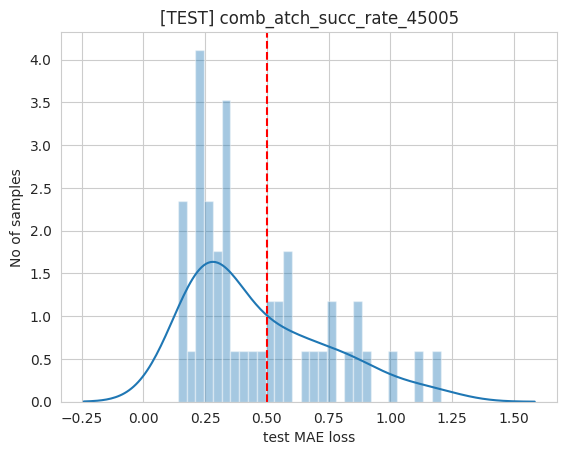

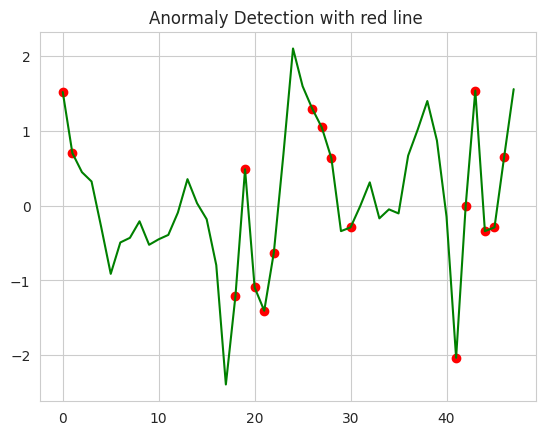

--------------------------------------------------------------------------------


In [28]:
# 이상치 확인 하기 
thresholds = [THRESHOLD_1, THRESHOLD_2, THRESHOLD_3]

for idx, (column_name,threshold_value) in enumerate(zip(selected_variable,thresholds )):
    final_df = detect_anomalies(
        y_test[:, idx],
        train_mae_loss[:, idx],
        test_mae_loss[:, idx],
        threshold_value,
    )
    plt.title(f"[TEST] {column_name}")
    sns.distplot(test_mae_loss[:, idx], bins=30, kde=True)
    plt.axvline(thresholds[idx],  color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    plt.title(f"Anormaly Detection with red line ")
    plot_anomalies(final_df)
    plt.show()
    print("-" * 80)

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>